In [1]:
import sys
sys.path.append('..')

import attack
import data_loader as dl

In [2]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt

In [3]:
# Load preprocessed data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_freemove(min_n_trips_per_user=5)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

Reading raw freemove geojson file...
Done.
Number of trajectories in loaded dataset: 1367
Number of users in loaded dataset: 57


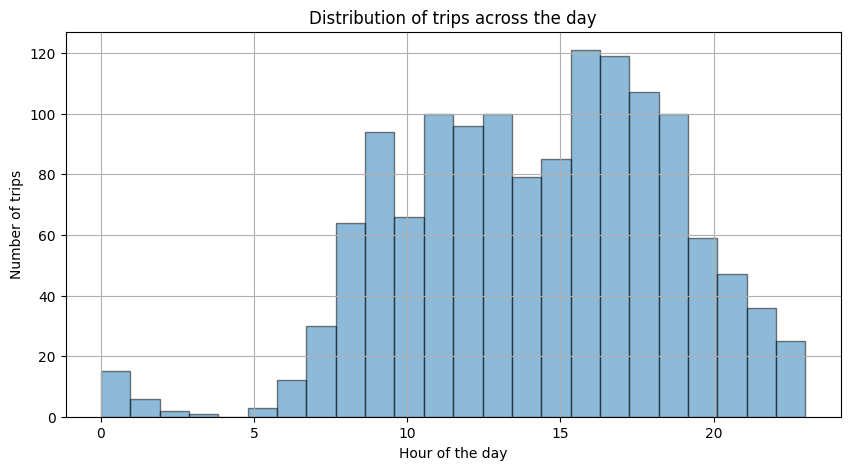

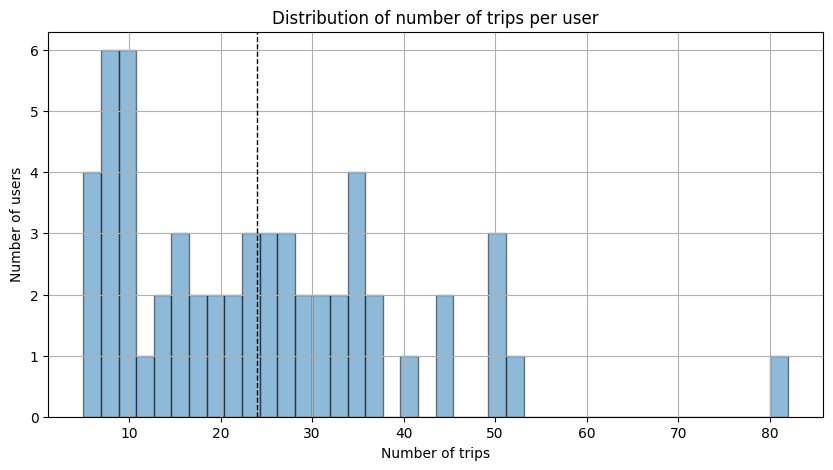

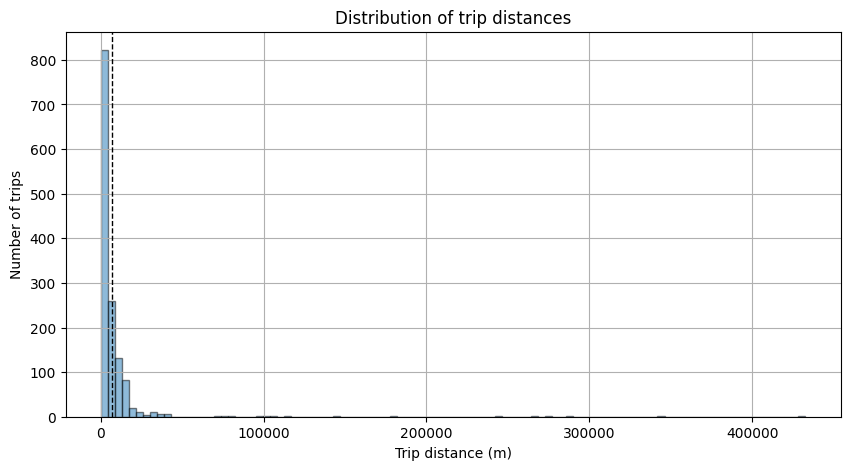

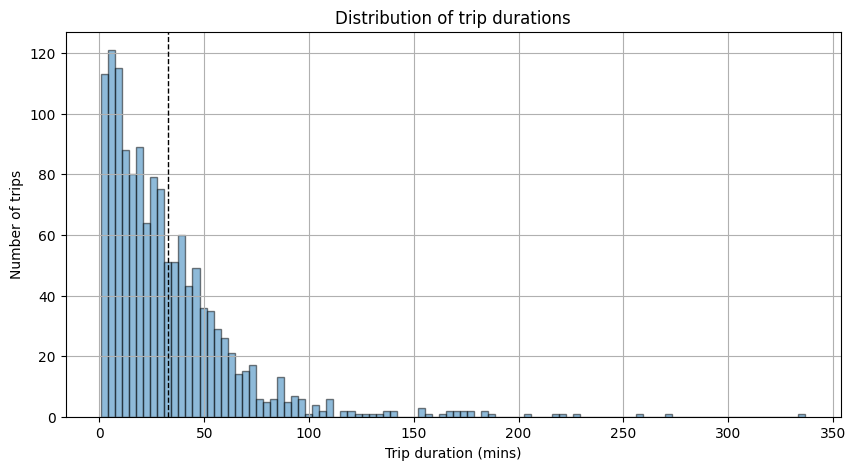


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 1336
Number of trips outside and therefore dropped: 31
Done.

Building mapping of trip chains...


100%|██████████| 1336/1336 [00:18<00:00, 72.96it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 472
Number of wrong matches: 20
Done.

Building trip chains...


100%|██████████| 1336/1336 [00:00<00:00, 19365.60it/s]


Done.

Merging trips...


100%|██████████| 1336/1336 [00:13<00:00, 95.84it/s] 


Done.
Number of trips that were matched at least once: 1318/1336
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 882
Done.

Building HL from start points...


c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 74 disconnected components.
 There are 39 islands with ids: 1, 4, 5, 6, 28, 32, 36, 37, 38, 39, 44, 45, 46, 47, 55, 56, 57, 68, 88, 89, 94, 95, 98, 99, 109, 110, 112, 113, 114, 117, 131, 132, 152, 153, 172, 173, 176, 179, 191.
  warnings.warn(message)


Done.

Building HL from end points...


c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 122 disconnected components.
 There are 49 islands with ids: 4, 23, 37, 50, 51, 52, 53, 59, 60, 97, 114, 115, 125, 126, 128, 130, 134, 146, 148, 154, 155, 156, 165, 197, 198, 201, 216, 223, 224, 238, 240, 243, 244, 261, 262, 268, 298, 300, 315, 316, 319, 327, 345, 353, 354, 384, 389, 410, 418.
  warnings.warn(message)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 140 disconnected components.
 There are 54 islands with ids: 7, 66, 104, 142, 143, 145, 152, 153, 201, 235, 236, 243, 244, 255, 261, 269, 272, 287, 288, 291, 302, 309, 319, 320, 323, 334, 339, 353, 354, 364, 365, 366, 367, 380, 387, 388, 405, 406, 417, 433, 463, 467, 469, 477, 478, 479, 491, 492, 525, 530, 535, 554, 563, 582.
  warnings.warn(mess

Done.

Combining HL from start points and end points...
Number of users for which at least on Home Location has been identified:  56
Number of unique HL tiles: 140
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 78/882
Number of trajectories (concatenated) that start AND end in a HL tile: 475/882
Number of trips that match different HL tiles with their SP and EP: 234
Done.

Matching double assigned trips to unique HL...
All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
Done.

Getting trajectories that happened during the same time...
Done.

Building clustering after HL matching step...


 18%|█▊        | 16/90 [00:00<00:00, 75.14it/s]

Running randomized subset search for 400 iterations with 103 trajectories...
Done. Length of longest subset:  26


 54%|█████▍    | 49/90 [00:01<00:01, 36.14it/s]

Running randomized subset search for 400 iterations with 44 trajectories...


 62%|██████▏   | 56/90 [00:02<00:01, 25.94it/s]

Done. Length of longest subset:  33
Running randomized subset search for 400 iterations with 44 trajectories...


 69%|██████▉   | 62/90 [00:02<00:01, 18.63it/s]

Done. Length of longest subset:  26


100%|██████████| 90/90 [00:03<00:00, 26.21it/s]


Done.

Clustering results after concatenation step:
Number of unique clusters: 882
Homogeneity: 0.994
Completeness: 0.574
V-measure: 0.728
Rand index: 0.977
ARI: 0.058
MI: 3.814
NMI: 0.728
AMI: 0.263
Cluster accuracy: 0.133

Clustering results after HL matching step:
Number of unique clusters: 291
Homogeneity: 0.896
Completeness: 0.722
V-measure: 0.799
Rand index: 0.982
ARI: 0.507
MI: 3.436
NMI: 0.799
AMI: 0.672
Cluster accuracy: 0.558


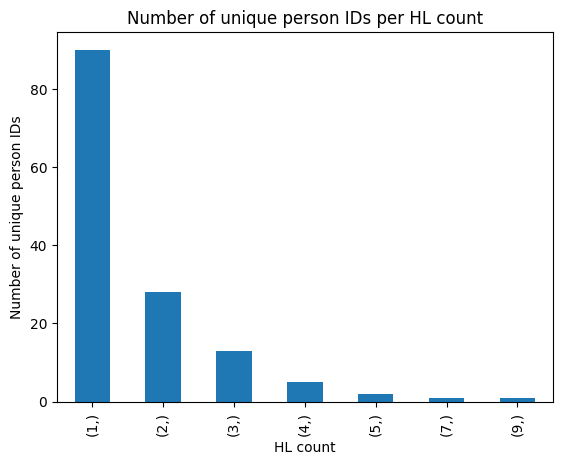

In [5]:
attack.plot_hour_of_day_distribution(raw_full_trip_gdf)
attack.plot_distribution_of_number_of_trips_per_user(raw_full_trip_gdf)
attack.plot_distribution_of_trip_distances(raw_full_trip_gdf)
attack.plot_distribution_of_trip_durations(raw_full_trip_gdf)

# Merge Start Points (SP) and End Points (EP) with Tessellation
print("\nMatching start and end points with tessellation...")
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)
print("Done.")

# Extract Full Trips that Start and End within Tessellation Area
print("\nExtracting trips that start and end within tessellation area...")
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)
print("Done.")

# Build mapping of trip chains
print('\nBuilding mapping of trip chains...')
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)
print('Done.')

# Evaluate Trip Chaining
print('\nEvaluating trip chaining...')
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)
print('Done.')

# Concatenate Trips
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)

# Extract data for concatenated trips
print('\nExtracting data for concatenated trips...')
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)
print('Done.')

# Build Clustering after Concatenation step
print('\nBuilding clustering after concatenation...')
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)
print('Done.')

# Build Home Locations (HL)
# Build HL from Start Points
print('\nBuilding HL from start points...')
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp)
print('Done.')
# Build HL from End Points
print('\nBuilding HL from end points...')
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_ep)
print('Done.')
# Combine HL from Start Points and End Points
print('\nCombining HL from start points and end points...')
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)
print('Done.')

print('\nMatching trips to HL...')
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)
print('Done.')

print('\nMatching double assigned trips to unique HL...')
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)
print('Done.')

# Get trajectories that happened during the same time
print('\nGetting trajectories that happened during the same time...')
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)
print('Done.')

# Build Clustering after HL matching step
print('\nBuilding clustering after HL matching step...')
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)
print('Done.')

# Evaluate clustering Results
print("\nClustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)
clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

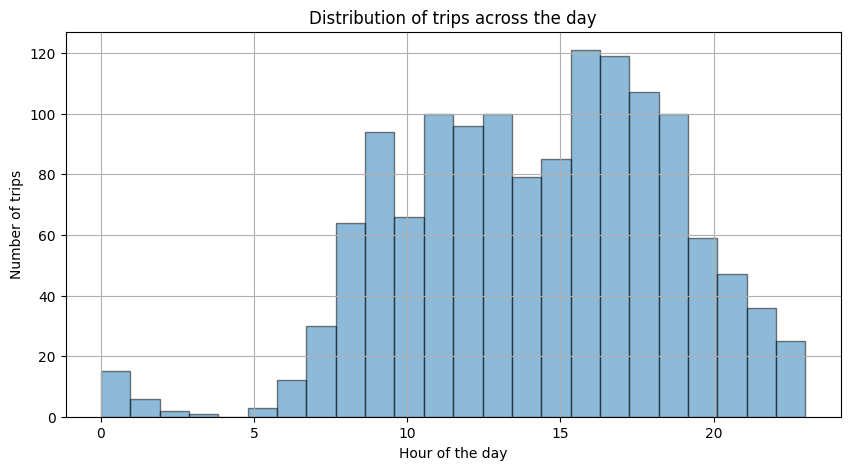

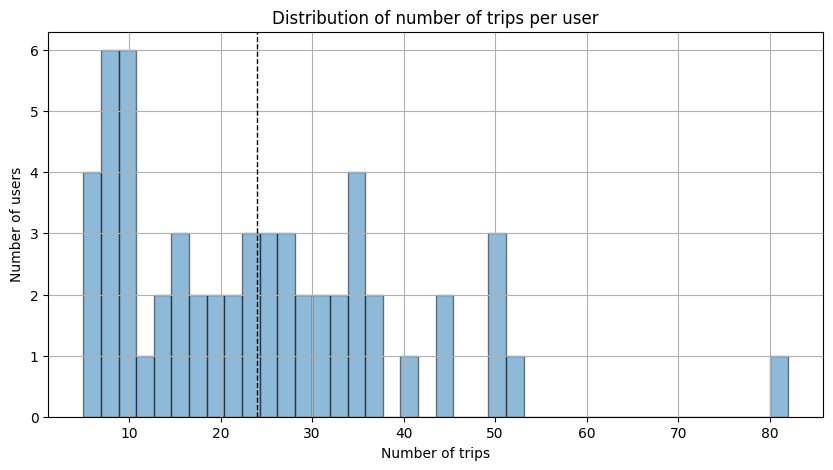

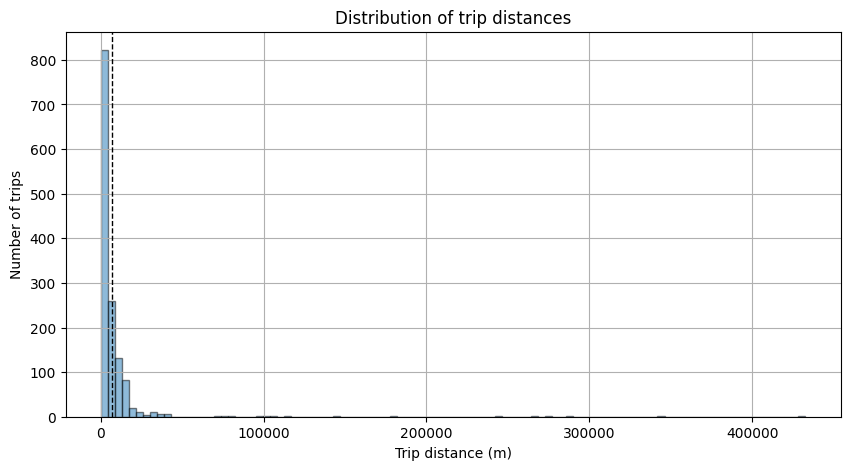

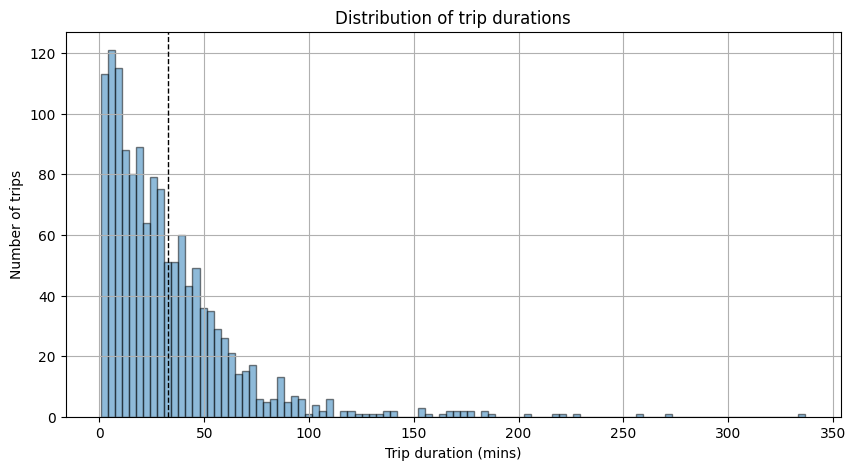


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 1336
Number of trips outside and therefore dropped: 31
Done.

Building mapping of trip chains...


100%|██████████| 1336/1336 [00:16<00:00, 80.85it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 472
Number of wrong matches: 20
Done.

Building trip chains...


100%|██████████| 1336/1336 [00:00<00:00, 37647.40it/s]


Done.

Merging trips...


100%|██████████| 1336/1336 [00:10<00:00, 129.58it/s]


Done.
Number of trips that were matched at least once: 1318/1336
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 882
Done.

Building HL from start points...


c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 74 disconnected components.
 There are 39 islands with ids: 1, 4, 5, 6, 28, 32, 36, 37, 38, 39, 44, 45, 46, 47, 55, 56, 57, 68, 88, 89, 94, 95, 98, 99, 109, 110, 112, 113, 114, 117, 131, 132, 152, 153, 172, 173, 176, 179, 191.
  warnings.warn(message)


Done.

Building HL from end points...


c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 122 disconnected components.
 There are 49 islands with ids: 4, 23, 37, 50, 51, 52, 53, 59, 60, 97, 114, 115, 125, 126, 128, 130, 134, 146, 148, 154, 155, 156, 165, 197, 198, 201, 216, 223, 224, 238, 240, 243, 244, 261, 262, 268, 298, 300, 315, 316, 319, 327, 345, 353, 354, 384, 389, 410, 418.
  warnings.warn(message)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 140 disconnected components.
 There are 54 islands with ids: 7, 66, 104, 142, 143, 145, 152, 153, 201, 235, 236, 243, 244, 255, 261, 269, 272, 287, 288, 291, 302, 309, 319, 320, 323, 334, 339, 353, 354, 364, 365, 366, 367, 380, 387, 388, 405, 406, 417, 433, 463, 467, 469, 477, 478, 479, 491, 492, 525, 530, 535, 554, 563, 582.
  warnings.warn(mess

Done.

Combining HL from start points and end points...
Number of users for which at least on Home Location has been identified:  56
Number of unique HL tiles: 140
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 78/882
Number of trajectories (concatenated) that start AND end in a HL tile: 475/882
Number of trips that match different HL tiles with their SP and EP: 234
Done.

Matching double assigned trips to unique HL...
All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
Done.

Getting trajectories that happened during the same time...
Done.

Building clustering after HL matching step...


 20%|██        | 18/90 [00:00<00:00, 87.63it/s]

Running randomized subset search for 400 iterations with 103 trajectories...
Done. Length of longest subset:  30


 48%|████▊     | 43/90 [00:01<00:01, 28.98it/s]

Running randomized subset search for 400 iterations with 44 trajectories...


 58%|█████▊    | 52/90 [00:02<00:01, 25.32it/s]

Done. Length of longest subset:  30
Running randomized subset search for 400 iterations with 44 trajectories...


 68%|██████▊   | 61/90 [00:02<00:01, 18.53it/s]

Done. Length of longest subset:  27


100%|██████████| 90/90 [00:03<00:00, 27.03it/s]


Done.

Clustering results after concatenation step:
Number of unique clusters: 882
Homogeneity: 0.994
Completeness: 0.574
V-measure: 0.728
Rand index: 0.977
ARI: 0.058
MI: 3.814
NMI: 0.728
AMI: 0.263
Cluster accuracy: 0.133

Clustering results after HL matching step:
Number of unique clusters: 289
Homogeneity: 0.890
Completeness: 0.718
V-measure: 0.795
Rand index: 0.981
ARI: 0.501
MI: 3.415
NMI: 0.795
AMI: 0.666
Cluster accuracy: 0.560

Clustering results after concatenation step:
Number of unique clusters: 882
Homogeneity: 0.994
Completeness: 0.574
V-measure: 0.728
Rand index: 0.977
ARI: 0.058
MI: 3.814
NMI: 0.728
AMI: 0.263
Cluster accuracy: 0.133

Clustering results after HL matching step:
Number of unique clusters: 289
Homogeneity: 0.890
Completeness: 0.718
V-measure: 0.795
Rand index: 0.981
ARI: 0.501
MI: 3.415
NMI: 0.795
AMI: 0.666
Cluster accuracy: 0.560

Writing trips of clusters to geojson...
{1: 14, 2: 14, 3: 89, 4: 66, 5: 66, 6: 66, 7: 7, 8: 58, 9: 59, 10: 19, 11: 88, 12: 96

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Done.

Rasterizing trips in clusters...


  0%|          | 0/580 [00:00<?, ?it/s]R[write to console]: Linking to GEOS 3.9.3, GDAL 3.5.2, PROJ 8.2.1; sf_use_s2() is TRUE

  0%|          | 1/580 [00:05<53:18,  5.52s/it]R[write to console]: Error: Cannot open "C:\Users\Bened\Documents\Git\Master-Thesis\freemove\temp\cluster_1.tif"; The source could be corrupt or not supported. See `st_drivers()` for a list of supported formats.

  0%|          | 1/580 [00:05<54:15,  5.62s/it]


RRuntimeError: Error: Cannot open "C:\Users\Bened\Documents\Git\Master-Thesis\freemove\temp\cluster_1.tif"; The source could be corrupt or not supported. See `st_drivers()` for a list of supported formats.


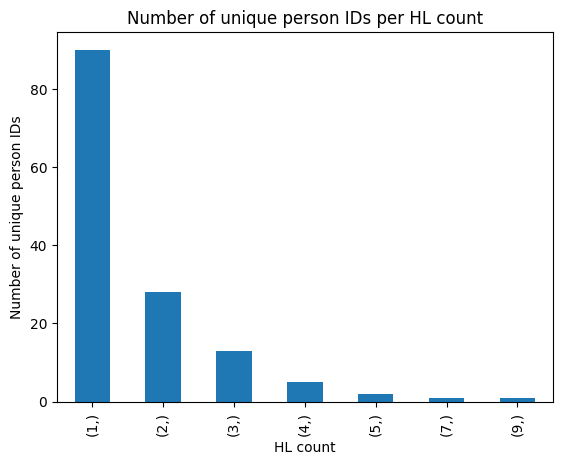

In [4]:
attack.run_full_attack(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf, city='berlin')